In [1]:
import shap
import pickle
import pandas as pd
from sklearn.preprocessing import StandardScaler
import lime
from tqdm import tqdm
from classification_utils import *

/Users/lucamoroni/Desktop/__WorkSpace/__Universita/unipi/DataMining/Data_Mining_22_23/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load dataset

In [2]:
data = pd.read_csv("dataset/cleaned_user_profiles.csv", index_col=0)

In [3]:
data.head()

name lang  bot           created_at  statuses_count  \
2353593986   Lamonica Raborn   en    1  2019-02-22 18:00:42              76   
2358850842     Lourie Botton   en    0  2019-02-26 03:02:32              54   
137959629   Dadan Syarifudin   en    1  2015-04-30 07:09:56              53   
466124818     Carletto Focia   it    1  2017-01-18 02:49:18              50   
2571493866         MBK Ebook   en    0  2019-06-18 19:30:21            7085   

            avg_length  avg_special_chars  urls_ratio  mentions_ratio  \
2353593986   62.340909          14.015152    0.000000        0.272727   
2358850842   69.082645          15.041322    0.000000        0.338843   
137959629    65.340909          14.694444    0.000000        0.000000   
466124818    86.944871          18.689463    0.022331        0.006281   
2571493866   72.311246          14.582073    0.000825        0.506461   

            hashtags_ratio  reply_count_mean  reply_count_std  \
2353593986        0.098485               0.0              0.0   
2358850842        0.024793               0.0              0.0   
137959629         0.000000               0.0              0.0   
466124818         0.072575               0.0              0.0   
2571493866        0.118229               0.0              0.0   

            favorite_count_mean  favorite_count_std  favorite_count_entropy  \
2353593986             0.037879            0.190903                0.232481   
2358850842             0.049587            0.217090                0.284639   
137959629              0.000000            0.000000                0.000000   
466124818              0.165387            0.530838                0.669155   
2571493866             0.056365            0.243387                0.317182   

            retweet_count_mean  retweet_count_std  
2353593986            0.037879           0.190903  
2358850842            0.024793           0.155495  
137959629             0.000000           0.000000  
466124818             0.826239          13.034008  
2571493866            0.016772           0.142619

In [4]:
#a descrption of the dataset
data.describe()

bot  statuses_count    avg_length  avg_special_chars  \
count  11508.000000    11508.000000  11508.000000       11508.000000   
mean       0.531456     5148.794751     67.100135          15.045892   
std        0.499031    18496.606420     12.755296           2.454106   
min        0.000000        0.000000     32.500000           9.644166   
25%        0.000000       53.000000     59.686796          13.553296   
50%        1.000000       57.000000     65.340909          14.694444   
75%        1.000000     2041.000000     74.254999          16.772205   
max        1.000000   399555.000000    104.449541          22.000000   

         urls_ratio  mentions_ratio  hashtags_ratio  reply_count_mean  \
count  11508.000000    11508.000000    11508.000000      11508.000000   
mean       0.031045        0.329076        0.088484          0.001967   
std        0.053379        0.315589        0.070828          0.007796   
min        0.000000        0.000000        0.000000          0.000000   
25%        0.000000        0.010260        0.045455          0.000000   
50%        0.005109        0.300971        0.070423          0.000000   
75%        0.037445        0.450781        0.113295          0.000000   
max        0.287760        1.210354        0.337268          0.044444   

       reply_count_std  favorite_count_mean  favorite_count_std  \
count     11508.000000         11508.000000        11508.000000   
mean          0.023941             0.084281            0.365536   
std           0.068508             0.109621            0.408358   
min           0.000000             0.000000            0.000000   
25%           0.000000             0.017751            0.136692   
50%           0.000000             0.045752            0.230747   
75%           0.000000             0.088862            0.451218   
max           0.333767             0.529903            2.183383   

       favorite_count_entropy  retweet_count_mean  retweet_count_std  
count            11508.000000        11508.000000       11508.000000  
mean                 0.385427            1.357545          14.574041  
std                  0.390777            2.827068          23.390000  
min                  0.000000            0.000000           0.000000  
25%                  0.119116            0.010526           0.104251  
50%                  0.268594            0.043478           0.238606  
75%                  0.491767            0.949402          24.144412  
max                  1.723913           12.902439         198.461303

In [5]:
train_set, test_set, train_label, test_label = prepare_data(data)

Classification features : ['created_at', 'statuses_count', 'avg_length', 'avg_special_chars', 'urls_ratio', 'mentions_ratio', 'hashtags_ratio', 'reply_count_mean', 'reply_count_std', 'favorite_count_mean', 'favorite_count_std', 'favorite_count_entropy', 'retweet_count_mean', 'retweet_count_std']


In [6]:
features = test_set.columns.to_list()

In [7]:
scaler = StandardScaler()

train_X = scaler.fit_transform(train_set)
test_X = scaler.transform(test_set)

In [8]:
with open("models_checkpoints/svm_no_lang.bin", "rb") as f:
    svm_model = pickle.load(f)

In [9]:
svm_model

SVC(C=10, kernel='linear', probability=True)

## Explain the results: SHAP

In [10]:
shap.initjs()

In [11]:
explainer = shap.KernelExplainer(svm_model.predict_proba, shap.sample(train_X, 20))

In [12]:
shap_values = explainer.shap_values(test_X[0:50])

  8%|█████████████▍                                                                                                                                                          | 4/50 [00:10<01:54,  2.49s/it]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a prep

In [13]:
shap.force_plot(explainer.expected_value[0], shap_values[0], test_X, link="logit",feature_names=features)

In [14]:
shap.force_plot(explainer.expected_value[1], shap_values[1], test_X, link="logit",feature_names=features)

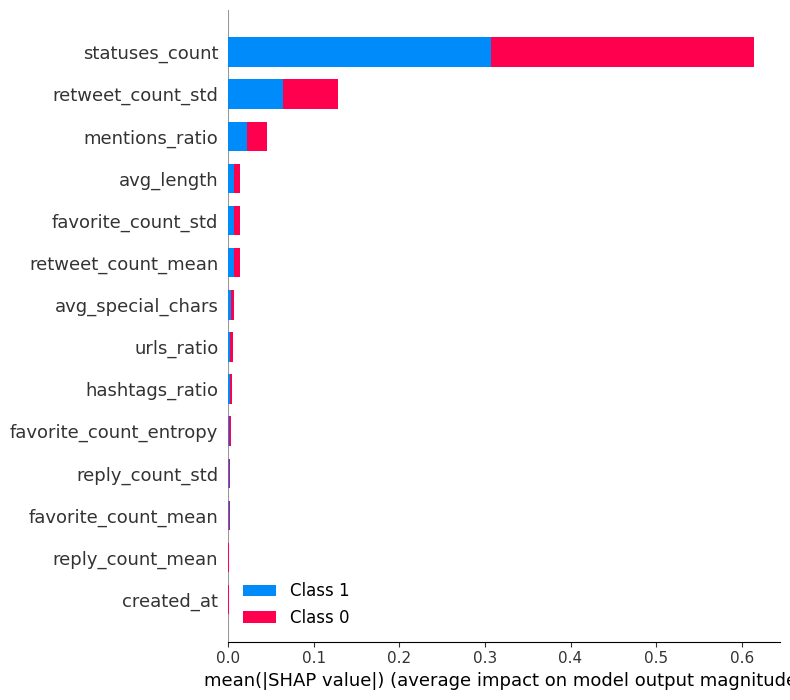

In [15]:
shap.summary_plot(shap_values, test_X[0:50], feature_names=features)

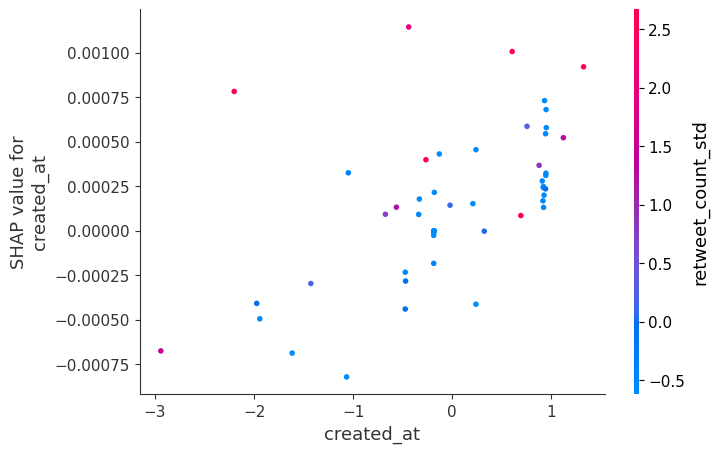

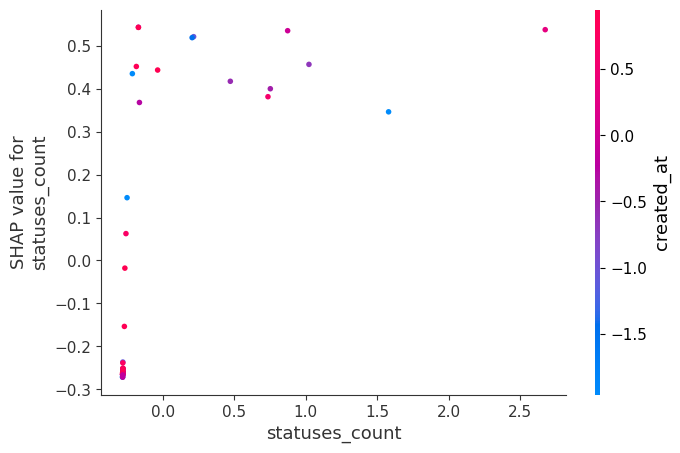

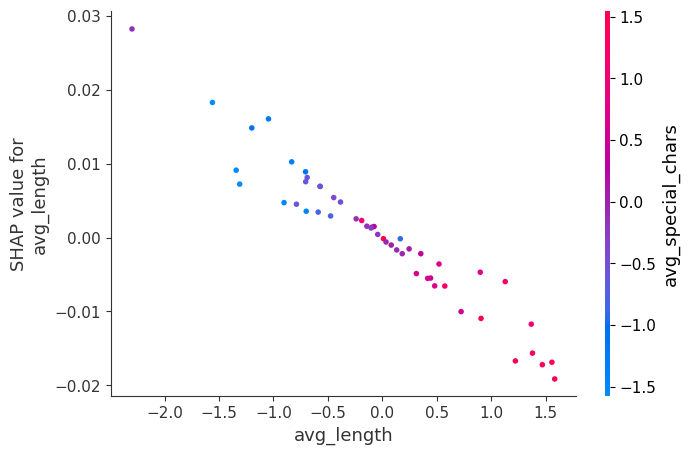

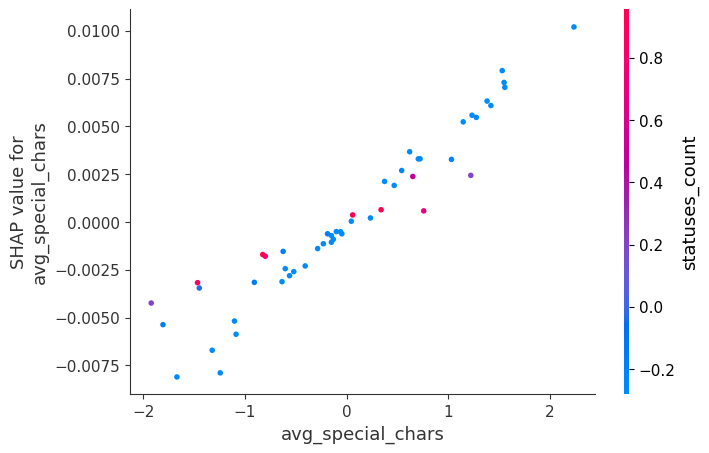

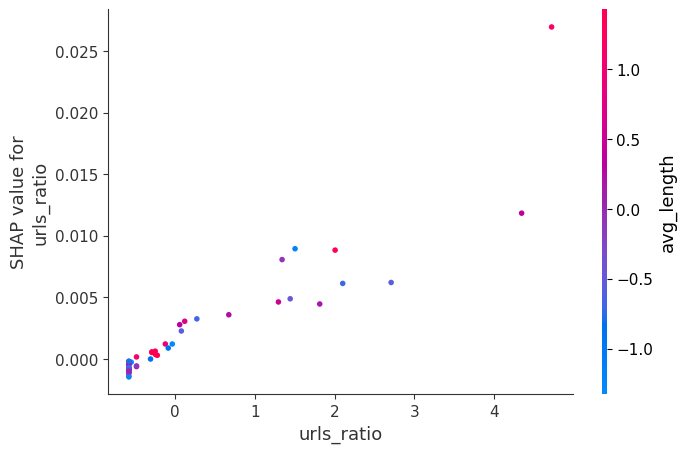

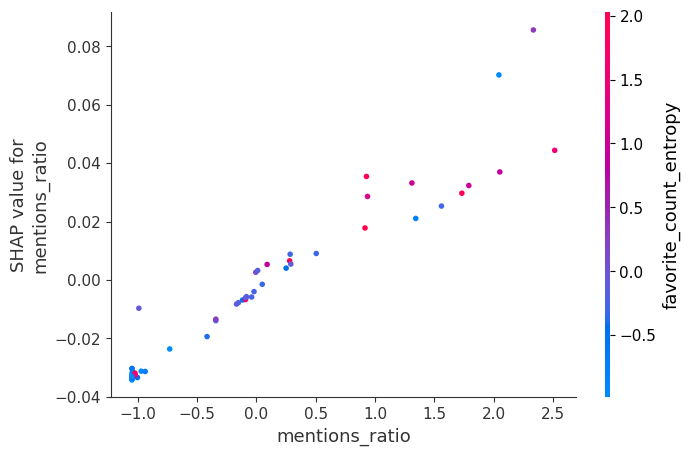

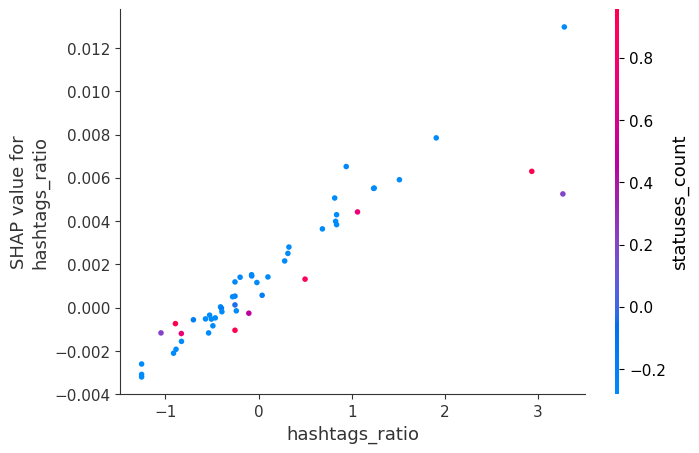

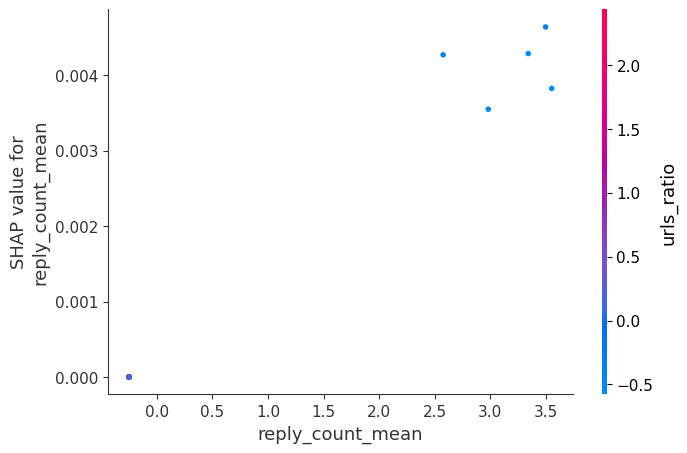

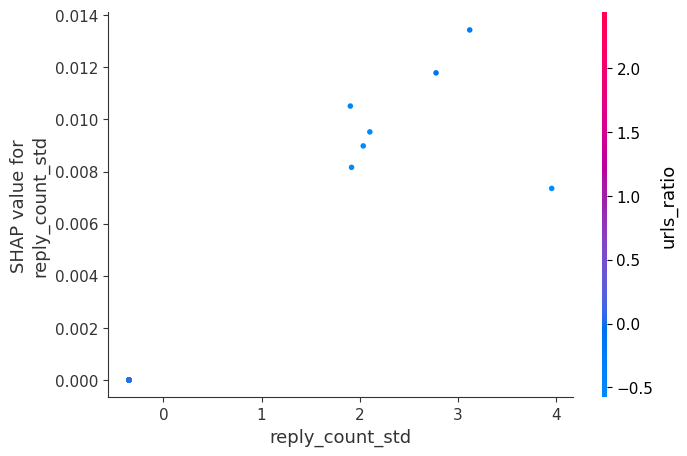

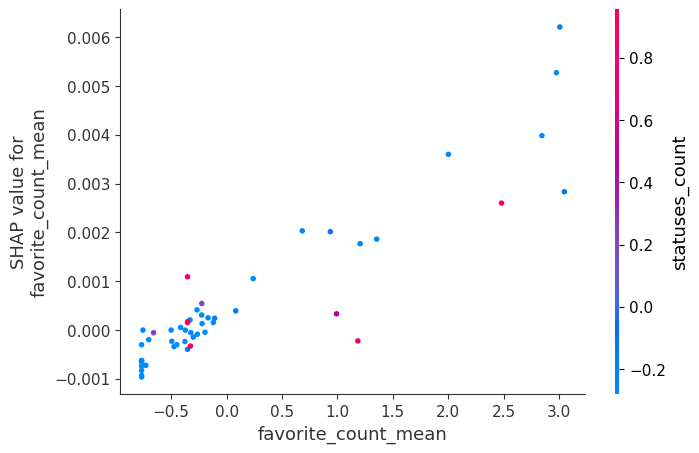

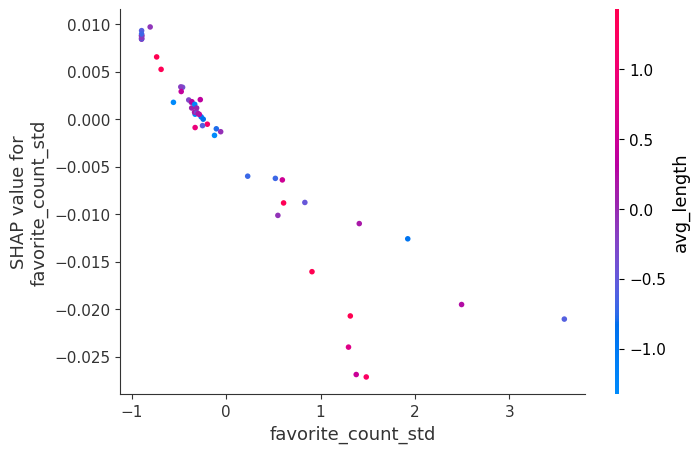

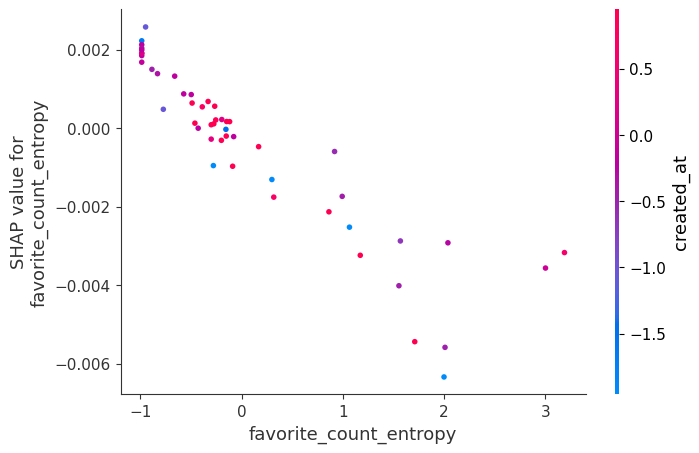

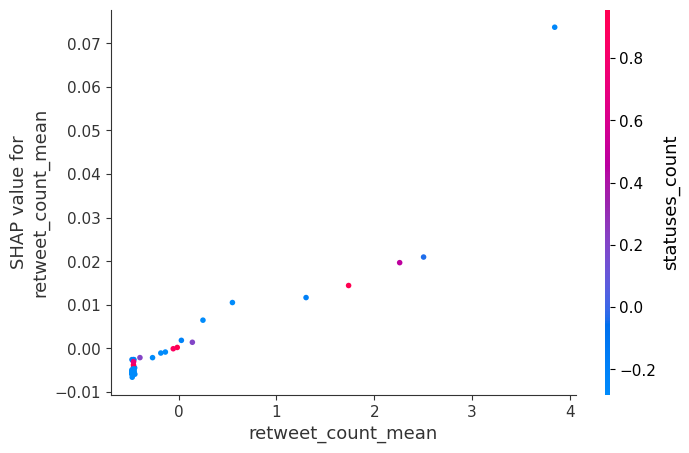

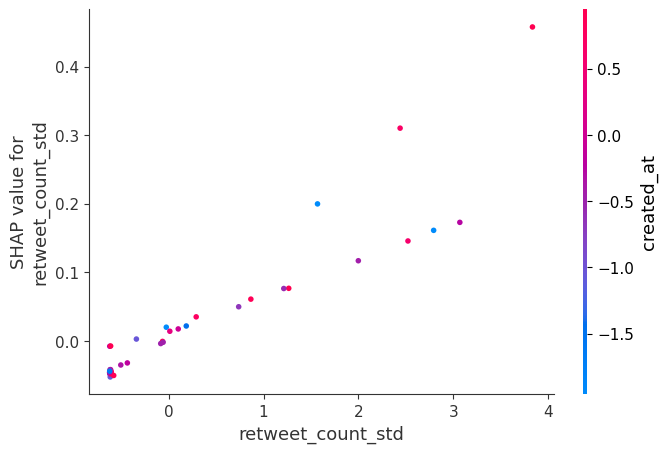

In [16]:
for feat in features:
    shap.dependence_plot(
        feat,
        shap_values[0], test_X[0:50], feature_names=features)

### Local Explain

In [17]:
pd.Series(test_X[12], features)

created_at               -0.474661
statuses_count           -0.280208
avg_length                1.470231
avg_special_chars         1.382683
urls_ratio               -0.290628
mentions_ratio           -1.023859
hashtags_ratio           -0.408329
reply_count_mean         -0.249507
reply_count_std          -0.349633
favorite_count_mean       2.846531
favorite_count_std        1.315516
favorite_count_entropy    2.009712
retweet_count_mean       -0.183823
retweet_count_std        -0.083702
dtype: float64

In [18]:
svm_model.predict([test_X[12]])

array([1])

In [19]:
shap.force_plot(explainer.expected_value[1], shap_values[1][12,:], feature_names=test_set.columns.to_list())

In [44]:
pd.Series(test_X[13], features)

created_at               -0.266171
statuses_count           -0.164011
avg_length                0.165300
avg_special_chars        -0.906947
urls_ratio                1.813993
mentions_ratio            0.915104
hashtags_ratio           -0.398440
reply_count_mean         -0.249507
reply_count_std          -0.349633
favorite_count_mean       3.048974
favorite_count_std        1.410440
favorite_count_entropy    2.038415
retweet_count_mean       -0.463506
retweet_count_std         3.068400
dtype: float64

In [40]:
test_label.iloc[13]

0

In [41]:
svm_model.predict([test_X[13]])

array([0])

In [43]:
shap.force_plot(explainer.expected_value[0], shap_values[0][13,:], feature_names=test_set.columns.to_list())

## Explain Model: LIME

In [23]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(train_X, feature_names = features)

In [24]:
exp = lime_explainer.explain_instance(test_X[0], svm_model.predict_proba, top_labels=0)
exp.show_in_notebook(show_table=True, show_all=True)

In [25]:
exp = lime_explainer.explain_instance(test_X[2], svm_model.predict_proba, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=True)

## Explain Model: Evaluation

### Lime

In [26]:
exp.local_exp

{1: [(1, 0.36144552606110847),
  (13, 0.07343096023505746),
  (5, 0.051773331527315544),
  (2, -0.025088736813493787),
  (11, 0.014668916879369328),
  (12, 0.011960549508798471),
  (0, -0.01067690200023591),
  (8, 0.008713979162754843),
  (3, -0.005829615509001662),
  (10, -0.005823429810556574)]}

In [27]:
from aix360.metrics import faithfulness_metric, monotonicity_metric

predicted_class = svm_model.predict([test_X[0]])[0]

le = exp.local_exp[predicted_class]

m = exp.as_map()

x = test_X[0]
coefs = np.zeros(x.shape[0])

for v in le:
    coefs[v[0]] = v[1]


base = np.zeros(x.shape[0])


print("Faithfulness: ", faithfulness_metric(svm_model, x, coefs, base))
print("Monotonity: ", monotonicity_metric(svm_model, x, coefs, base))

Faithfulness:  0.9770648514907976
Monotonity:  False


In [28]:
ncases = 100
fait = np.zeros(ncases)
for i in tqdm(range(ncases)):
    predicted_class = svm_model.predict(test_X[i].reshape(1,-1))[0]
    exp = lime_explainer.explain_instance(test_X[i], svm_model.predict_proba, top_labels=1)
    le = exp.local_exp[predicted_class]
    m = exp.as_map()
    
    x = test_set.values[i]
    coefs = np.zeros(x.shape[0])
    
    for v in le:
        coefs[v[0]] = v[1]
    fait[i] = faithfulness_metric(svm_model, test_X[i], coefs, base)
    
fait[np.isnan(fait)] = 0

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.78it/s]


In [29]:
print("Faithfulness metric mean: ",np.mean(fait))
print("Faithfulness metric std. dev.:", np.std(fait))

Faithfulness metric mean:  0.5261151833971826
Faithfulness metric std. dev.: 0.7073204331236747


### Shap

In [30]:
print("Faithfulness: ", faithfulness_metric(svm_model, x, shap_values[predicted_class][0], base))
print("Monotonity: ", monotonicity_metric(svm_model, x, shap_values[predicted_class][0], base))

Faithfulness:  8.721455398087317e-17
Monotonity:  False


In [31]:
ncases = 20 # max shap values istances
fait = np.zeros(ncases)
for i in tqdm(range(ncases)):
    predicted_class = svm_model.predict(test_X[i].reshape(1,-1))[0]
    fait[i] = faithfulness_metric(svm_model, test_X[i], shap_values[predicted_class][i], base)

fait[np.isnan(fait)] = 0

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 185.15it/s]


In [32]:
print("Faithfulness metric mean: ",np.mean(fait))
print("Faithfulness metric std. dev.:", np.std(fait))

Faithfulness metric mean:  0.5587316467676546
Faithfulness metric std. dev.: 0.7024506344026994
